In [1]:
from svgpathtools import svg2paths, Path, Line, CubicBezier, QuadraticBezier, Arc
import numpy as np
import csv
from collections import defaultdict
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def extract_points_from_path(path_segment, num_samples=100):
    if isinstance(path_segment, (Line, CubicBezier, QuadraticBezier, Arc)):
        return [path_segment.point(t) for t in np.linspace(0, 1, num_samples)]
    return []

In [3]:
svg_file = './data/problems/frag0.svg' 
paths, _ = svg2paths(svg_file)

all_points = []
for curve_index, path in enumerate(paths):
    for segment in path:
        points = extract_points_from_path(segment)
        all_points.extend([(curve_index, 0.0000, float(p.real), float(p.imag)) for p in points])

with open('out.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['index', 'constant', 'x', 'y'])
    for index, constant, x, y in all_points:
        writer.writerow([index, constant, np.float64(x), np.float64(y)])

In [4]:
def euclidean_distance(point1: np.ndarray, point2: np.ndarray) -> float:
    return np.linalg.norm(point1 - point2)

def rdp(points: np.ndarray, epsilon: float) -> List[Tuple[float, float]]:
    dmax = 0
    index = 0
    end = len(points)
    for i in range(1, end - 1):
        d = euclidean_distance(points[i], points[0]) + euclidean_distance(points[i], points[-1]) - euclidean_distance(points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d

    if dmax > epsilon:
        results1 = rdp(points[:index + 1], epsilon)
        results2 = rdp(points[index:], epsilon)
        return results1[:-1] + results2
    else:
        return [tuple(points[0]), tuple(points[-1])]

def average_close_vertices(curves: defaultdict, tolerance: float) -> defaultdict:
    all_points = []
    for points in curves.values():
        all_points.extend(points)

    clusters = []
    for point in all_points:
        added = False
        for cluster in clusters:
            if any(euclidean_distance(np.array(cp), np.array(point)) <= tolerance for cp in cluster):
                cluster.append(point)
                added = True
                break
        if not added:
            clusters.append([point])

    averaged_points = {}
    for cluster in clusters:
        avg_point = tuple(np.mean(cluster, axis=0))
        for point in cluster:
            averaged_points[point] = avg_point

    new_curves = defaultdict(list)
    for curve_no, points in curves.items():
        new_points = [averaged_points[point] for point in points]
        new_curves[curve_no] = new_points

    return new_curves

In [5]:
curves = defaultdict(list)
with open('out.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  
    for row in reader:
        try:
            curve_no = int(float(row[0])) 
            x = float(row[2])
            y = float(row[3])
            curves[curve_no].append((x, y))
        except ValueError as e:
            print(f"Skipping line due to error: {e}")

In [6]:
curves

defaultdict(list,
            {0: [(41.942, 68.98),
              (41.81014896026895, 69.13892342154325),
              (41.678717852950484, 69.29817831204609),
              (41.54770787767482, 69.45776433759079),
              (41.41712023407218, 69.61768116425968),
              (41.286956121772775, 69.77792845813508),
              (41.157216740406824, 69.93850588529928),
              (41.027903289604545, 70.09941311183461),
              (40.89901696899616, 70.26064980382336),
              (40.770558978211874, 70.42221562734787),
              (40.64253051688191, 70.58411024849042),
              (40.51493278463649, 70.74633333333334),
              (40.38776698110583, 70.90888454795893),
              (40.261034305920134, 71.07176355844952),
              (40.13473595870963, 71.2349700308874),
              (40.008873139104544, 71.39850363135487),
              (39.88344704673508, 71.56236402593429),
              (39.758458881231455, 71.72655088070792),
              (39.63390

In [7]:
epsilon_initial = 1.0  
simplified_curves = defaultdict(list)
for curve_no, points in curves.items():
    points_array = np.array(points)
    simplified_points = rdp(points_array, epsilon_initial)
    simplified_curves[curve_no] = simplified_points

In [8]:
simplified_curves

defaultdict(list,
            {0: [(41.942, 68.98),
              (24.879349361382413, 113.25390232907588),
              (36.89100000000002, 157.80800000000002)],
             1: [(176.5, 67.5),
              (153.66719283643496, 44.950373247833916),
              (121.20065848465265, 35.57279582066971),
              (77.20529629629624, 43.384074074074086),
              (41.941999999999894, 68.98000000000002)],
             2: [(36.891, 157.808),
              (63.655899453673555, 182.66043734147925),
              (101.3309385220432, 194.11631178842805),
              (136.48421876246394, 188.60492946194924),
              (166.49999999999997, 167.4999999999998)],
             3: [(42.964, 70.031),
              (74.74200380089023, 84.78426748455887),
              (82.3230108512943, 101.95348421053716),
              (73.35825770097672, 142.4150728775357),
              (36.89100000000001, 157.80800000000002)],
             4: [(166.5, 167.5),
              (189.66831254695717, 11

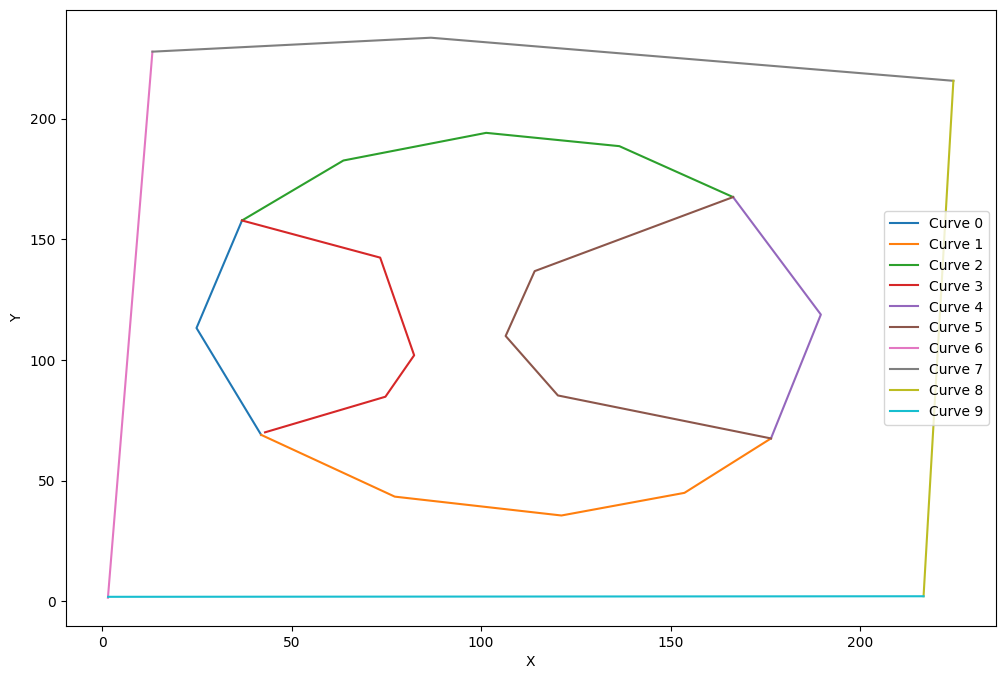

In [9]:
plt.figure(figsize=(12, 8))
for curve_no, points in simplified_curves.items():
    final_points_x, final_points_y = zip(*points)
    plt.plot(final_points_x, final_points_y, label=f'Curve {curve_no}')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [16]:
from collections import defaultdict
import math

# Input dictionary of polylines


# Helper function to check if two points are near each other
def points_near(p1, p2, threshold=2.0):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2) < threshold

# Helper function to find the midpoint between two points
def midpoint(p1, p2):
    return ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)

# Create an empty adjacency list
adj_list = defaultdict(list)

# Iterate through each pair of polylines and update their endpoints if they are near
for i in range(len(simplified_curves)):
    for j in range(len(simplified_curves)):
        if i != j:
            polyline_i = simplified_curves[i]
            polyline_j = simplified_curves[j]
            for index_i, point_i in enumerate(polyline_i):
                for index_j, point_j in enumerate(polyline_j):
                    if points_near(point_i, point_j):
                        # Calculate the midpoint
                        mid_point = midpoint(point_i, point_j)
                        # Update the endpoints in the original polylines
                        simplified_curves[i][index_i] = mid_point
                        simplified_curves[j][index_j] = mid_point

simplified_curves = {k: [(round(x, 2), round(y, 2)) for x, y in v] for k, v in simplified_curves.items()}
print("Updated Polylines:")
for key, value in simplified_curves.items():
    print(f"{key}: {value}")




Updated Polylines:
0: [(42.28, 69.33), (24.88, 113.25), (36.89, 157.81)]
1: [(176.5, 67.5), (153.67, 44.95), (121.2, 35.57), (77.21, 43.38), (42.28, 69.33)]
2: [(36.89, 157.81), (63.66, 182.66), (101.33, 194.12), (136.48, 188.6), (166.5, 167.5)]
3: [(42.28, 69.33), (74.74, 84.78), (82.32, 101.95), (73.36, 142.42), (36.89, 157.81)]
4: [(166.5, 167.5), (189.67, 118.82), (176.5, 67.5)]
5: [(176.5, 67.5), (120.27, 85.31), (106.47, 109.95), (114.13, 136.82), (166.5, 167.5)]
6: [(13.24, 227.76), (1.53, 1.69)]
7: [(224.65, 215.68), (86.74, 233.53), (13.24, 227.76)]
8: [(216.78, 2.11), (224.65, 215.68)]
9: [(1.53, 1.69), (216.78, 2.11)]


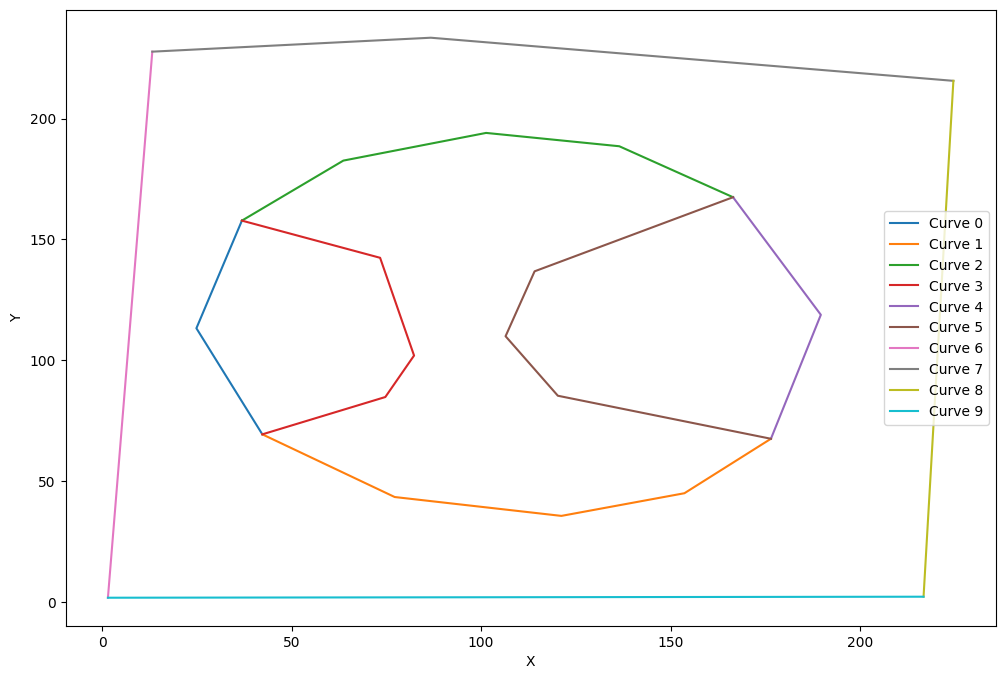

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
for curve_no, points in simplified_curves.items():
    final_points_x, final_points_y = zip(*points)
    plt.plot(final_points_x, final_points_y, label=f'Curve {curve_no}')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [18]:
for i in simplified_curves:
    for j in simplified_curves:
        if i != j:
            # Check if polylines i and j share any endpoint
            if any(points_near(p1, p2, threshold=1e-9) for p1 in simplified_curves[i] for p2 in simplified_curves[j]):
                adj_list[i].append(j)
# Print the adjacency list
print("\nAdjacency List:")
print(dict(adj_list))


Adjacency List:
{0: [1, 2, 3], 1: [0, 3, 4, 5], 2: [0, 3, 4, 5], 3: [0, 1, 2], 4: [1, 2, 5], 5: [1, 2, 4], 6: [7, 9], 7: [6, 8], 8: [7, 9], 9: [6, 8]}
